In [2]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hem-3-folder/dataset/validation/no/aug_82_4270.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_46_3843.png
/kaggle/input/hem-3-folder/dataset/validation/no/173.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_0_6383.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_46_4961.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_61_630.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_40_2606.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_96_2781.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_29_4856.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_41_4007.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_27_152.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_98_2145.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_1_5807.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_13_4833.png
/kaggle/input/hem-3-folder/dataset/validation/no/162.png
/kaggle/input/hem-3-folder/dataset/validation

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
import cv2
import shutil
import itertools

import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras.models import Model, Sequential
from keras.layers import TimeDistributed, Dense, Flatten, Dropout, Bidirectional, LSTM, GRU
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

RANDOM_SEED = 42

In [4]:
train_dir = "../input/hem-3-folder/dataset/train/"
validation_dir = "../input/hem-3-folder/dataset/validation/"
test_dir = "../input/hem-3-folder/dataset/test/"

In [5]:
def load_data(dir_path):
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [6]:
X_train, y_train, labels = load_data(train_dir)
X_test, y_test, _ = load_data(test_dir)
X_val, y_val, _ = load_data(validation_dir)

100%|██████████| 2/2 [00:16<00:00,  8.32s/it]


1536 images loaded from ../input/hem-3-folder/dataset/train/ directory.


100%|██████████| 2/2 [00:05<00:00,  2.58s/it]


480 images loaded from ../input/hem-3-folder/dataset/test/ directory.


100%|██████████| 2/2 [00:04<00:00,  2.07s/it]

384 images loaded from ../input/hem-3-folder/dataset/validation/ directory.


In [7]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(1536, 227, 227, 3)
(480, 227, 227, 3)
(384, 227, 227, 3)


In [8]:
X_train = np.array([cv2.resize(image, (224, 224)) for image in X_train])
X_test = np.array([cv2.resize(image, (224, 224)) for image in X_test])
X_val = np.array([cv2.resize(image, (224, 224)) for image in X_val])

In [9]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(1536, 224, 224, 3)
(480, 224, 224, 3)
(384, 224, 224, 3)


In [10]:
input_shape = (224,224, 3)
batch_size = 32

In [11]:
training_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)

In [12]:
train_generator = training_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

val_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 1536 images belonging to 2 classes.
Found 384 images belonging to 2 classes.


In [13]:
pretrained_resnet152_model = tf.keras.applications.resnet.ResNet152(weights='imagenet', include_top=False, input_shape=[224, 224, 3])
pretrained_resnet152_model.trainable = False

2022-03-15 19:53:39.271721: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 19:53:39.369237: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 19:53:39.369986: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 19:53:39.371187: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

234708992/234698864 [==============================] - 1s 0us/step


In [14]:
def print_layer_trainable():
    for layer in pretrained_resnet152_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

# print_layer_trainable()

print('Num layers, ', len(pretrained_resnet152_model.layers))

Num layers,  515


In [15]:
from keras.layers import TimeDistributed, Dense, Flatten, Dropout, Bidirectional, LSTM, GRU

model_resnet152 = tf.keras.Sequential([
                             pretrained_resnet152_model,
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(1024, activation='relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1, activation='sigmoid')
                             ])

model_resnet152.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

model_resnet152.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 7, 7, 2048)        58370944  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              102761472 
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 161,133,441
Trainable params: 102,762,497
Non-trainable params: 58,370,944
_________________________________________________________________


In [16]:
EPOCHS = 50
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
#     monitor='val_loss',
    factor=0.6,
    patience=3,
    min_lr=1e-6,
#     min_delta=0.000001,
    verbose=1)

# es = EarlyStopping(
#     monitor='val_accuracy', 
#     mode='max',
#     patience=6
# )
filename = 'resnet152.h5'
check_pt = ModelCheckpoint(
    filename,
    monitor="val_accuracy",
#     monitor='val_loss',
    verbose=1,
    save_best_only=True
)

# history = model.fit(train_generator, epochs=EPOCHS, batch_size=16, validation_data=val_generator, callbacks=[reduce_lr, es, check_pt])
history = model_resnet152.fit(train_generator, epochs=EPOCHS, batch_size=16, validation_data=val_generator, callbacks=[reduce_lr, check_pt])


2022-03-15 19:53:47.886015: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-03-15 19:53:56.424237: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


48/48 [==============================] - 26s 255ms/step - loss: 1.1183 - accuracy: 0.5801 - val_loss: 0.5362 - val_accuracy: 0.7161

Epoch 00001: val_accuracy improved from -inf to 0.71615, saving model to resnet152.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
48/48 [==============================] - 10s 194ms/step - loss: 0.5593 - accuracy: 0.7188 - val_loss: 0.4944 - val_accuracy: 0.7656

Epoch 00002: val_accuracy improved from 0.71615 to 0.76562, saving model to resnet152.h5
Epoch 3/50
48/48 [==============================] - 10s 202ms/step - loss: 0.5147 - accuracy: 0.7376 - val_loss: 0.4996 - val_accuracy: 0.7526

Epoch 00003: val_accuracy did not improve from 0.76562
Epoch 4/50
48/48 [==============================] - 9s 193ms/step - loss: 0.5331 - accuracy: 0.7311 - val_loss: 0.5712 - val_accuracy: 0.6667

Epoch 00004: val_accuracy did not improve from 0.76562
Epoch 5/50
48/48 [==============================] - 9s 194ms/step - loss: 0.4903 - accuracy: 0.7461 - val_loss: 0.4602 - val_accuracy: 0.7760

Epoch 00005: val_accuracy improved from 0.76562 to 0.77604, saving model to resnet152.h5
Epoch 6/50
48/48 [==============================] - 10s 201ms/step - loss: 0.4394 - accuracy: 0.7852 - val_loss: 0.5690 - val_accuracy: 0.

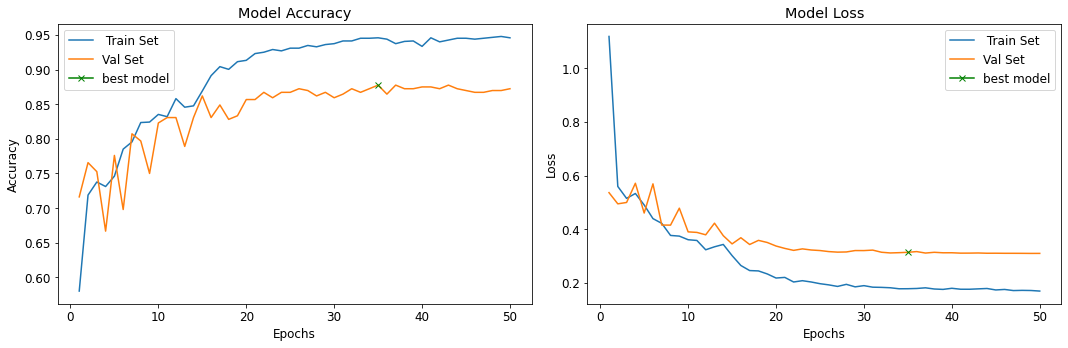

In [25]:
epochs_range = range(1, len(history.epoch) + 1)
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history["accuracy"], label=' Train Set')
plt.plot(epochs_range, history.history["val_accuracy"], label='Val Set')
plt.plot(35, 0.8776, marker="x", color="g", label="best model")
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.title('Model Accuracy')
# epoch: 35 loss: 0.1781 - accuracy: 0.9460 - val_loss: 0.3138 - val_accuracy: 0.8776
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history["loss"], label=' Train Set')
plt.plot(epochs_range, history.history["val_loss"], label='Val Set')
plt.plot(35, 0.3138, marker="x", color="g", label="best model")
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend(loc="best")
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [18]:
from tensorflow.keras.models import load_model
saved_model = load_model('./resnet152.h5', compile = False)

saved_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

In [21]:
# validation set
predictions = saved_model.predict(X_val / 255)
predictions = [1 if x>0.5 else 0 for x in predictions]
# predictions = [1 if x>0.4 else 0 for x in predictions]

_, train_acc = saved_model.evaluate(X_train / 255, y_train, verbose=0)
_, val_acc = saved_model.evaluate(X_val / 255, y_val, verbose=0)

print('Train: %.4f, Val: %.4f' % (train_acc, val_acc))

accuracy = accuracy_score(y_val, predictions)
print('Validation Accuracy = %.4f' % accuracy)

# precision: tp / (tp + fp)
precision = precision_score(y_val, predictions)
print('Precision: %f' % precision)

  # recall: tp / (tp + fn)
recall = recall_score(y_val, predictions)
print('Recall: %f' % recall)

  # f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, predictions)
print('F1 score: %f' % f1)

#KAPPA SCORE
kappa = cohen_kappa_score(y_val, predictions)
print('Cohens kappa: %f' % kappa)

  # ROC AUC
auc = roc_auc_score(y_val, predictions)
print('ROC AUC: %f' % auc)
 
# confusion matrix
matrix = confusion_matrix(y_val, predictions)
print(matrix)

tn, fp, fn, tp = matrix.ravel()
print("True positive:", tp, ", True negative:", tn,
            ", False positive:", fp, ", False negative:", fn)

Train: 0.9323, Val: 0.8490
Validation Accuracy = 0.8490
Precision: 0.885057
Recall: 0.802083
F1 score: 0.841530
Cohens kappa: 0.697917
ROC AUC: 0.848958
[[172  20]
 [ 38 154]]
True positive: 154 , True negative: 172 , False positive: 20 , False negative: 38


Train: 0.9323, Test: 0.8125
Test Accuracy = 0.8125
Precision: 0.847222
Recall: 0.762500
F1 score: 0.802632
Cohens kappa: 0.625000
ROC AUC: 0.812500
[[207  33]
 [ 57 183]]
True positive: 183 , True negative: 207 , False positive: 33 , False negative: 57
Sensitivity: 0.7625
Specificity: 0.8625


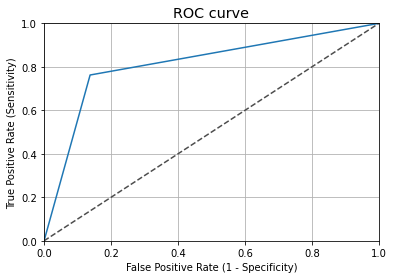

In [22]:
# test set (best)
predictions = saved_model.predict(X_test / 255)
predictions = [1 if x>0.5 else 0 for x in predictions]

_, train_acc = saved_model.evaluate(X_train / 255, y_train, verbose=0)
_, test_acc = saved_model.evaluate(X_test / 255, y_test, verbose=0)

print('Train: %.4f, Test: %.4f' % (train_acc, test_acc))

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.4f' % accuracy)

# precision: tp / (tp + fp)
precision = precision_score(y_test, predictions)
print('Precision: %f' % precision)

  # recall: tp / (tp + fn)
recall = recall_score(y_test, predictions)
print('Recall: %f' % recall)

  # f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predictions)
print('F1 score: %f' % f1)

#KAPPA SCORE
kappa = cohen_kappa_score(y_test, predictions)
print('Cohens kappa: %f' % kappa)

  # ROC AUC
auc = roc_auc_score(y_test, predictions)
print('ROC AUC: %f' % auc)
 
# confusion matrix
matrix = confusion_matrix(y_test, predictions)
print(matrix)

tn, fp, fn, tp = matrix.ravel()
print("True positive:", tp, ", True negative:", tn,
            ", False positive:", fp, ", False negative:", fn)

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

fpr, tpr, thresholds = roc_curve(y_test, predictions)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

Train: 0.9382, Test: 0.8229
Test Accuracy = 0.8229
Precision: 0.835498
Recall: 0.804167
F1 score: 0.819533
Cohens kappa: 0.645833
ROC AUC: 0.822917
[[202  38]
 [ 47 193]]
True positive: 193 , True negative: 202 , False positive: 38 , False negative: 47
Sensitivity: 0.8042
Specificity: 0.8417


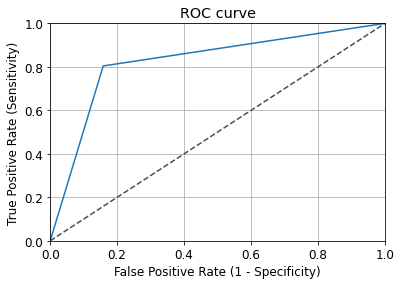

In [27]:
# test set (full epoch)
predictions = model_resnet152.predict(X_test / 255)
predictions = [1 if x>0.5 else 0 for x in predictions]

_, train_acc = model_resnet152.evaluate(X_train / 255, y_train, verbose=0)
_, test_acc = model_resnet152.evaluate(X_test / 255, y_test, verbose=0)

print('Train: %.4f, Test: %.4f' % (train_acc, test_acc))

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.4f' % accuracy)

# precision: tp / (tp + fp)
precision = precision_score(y_test, predictions)
print('Precision: %f' % precision)

  # recall: tp / (tp + fn)
recall = recall_score(y_test, predictions)
print('Recall: %f' % recall)

  # f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predictions)
print('F1 score: %f' % f1)

#KAPPA SCORE
kappa = cohen_kappa_score(y_test, predictions)
print('Cohens kappa: %f' % kappa)

  # ROC AUC
auc = roc_auc_score(y_test, predictions)
print('ROC AUC: %f' % auc)
 
# confusion matrix
matrix = confusion_matrix(y_test, predictions)
print(matrix)

tn, fp, fn, tp = matrix.ravel()
print("True positive:", tp, ", True negative:", tn,
            ", False positive:", fp, ", False negative:", fn)

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

fpr, tpr, thresholds = roc_curve(y_test, predictions)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)